Required libraries:

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sounddevice as sd
import soundfile as sf
import warnings
import random
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

warnings.filterwarnings("ignore")

Data preprocessing:

Data from: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [5]:
train_dataset = './input/'
labels = os.listdir(train_dataset)
for label in labels:
    if not os.path.isdir(train_dataset + '/' + label):
        labels.remove(label)
labels.remove('_background_noise_')
chosen_labels = np.random.choice(labels, 5, replace=False)
print(chosen_labels)


['marvin' 'five' 'bed' 'stop' 'sheila']


In [85]:
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

Preprocessing nine...
Preprocessing eight...
Preprocessing yes...
Preprocessing wow...
Preprocessing stop...


In [86]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

In [87]:
y = to_categorical(y, num_classes=len(chosen_labels))

In [88]:
X = np.array(all_waves).reshape(-1, 8000, 1)

In [89]:
print(X.shape)
print(y.shape)

(10141, 8000, 1)
(10141, 5)


In [90]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))

X_train len 8112
X_val len 2029


In [99]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (8112, 8000, 1)
y_train shape:  (8112, 5)
X_val shape:  (2029, 8000, 1)
y_val shape:  (2029, 5)


Model

In [37]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [102]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3328 - loss: 1.4698
Epoch 1: val_accuracy improved from -inf to 0.58945, saving model to best_model.hdf5.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.3332 - loss: 1.4692 - val_accuracy: 0.5895 - val_loss: 1.0624
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6105 - loss: 0.9752
Epoch 2: val_accuracy improved from 0.58945 to 0.66042, saving model to best_model.hdf5.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6107 - loss: 0.9747 - val_accuracy: 0.6604 - val_loss: 0.9399
Epoch 3/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7693 - loss: 0.6422
Epoch 3: val_accuracy improved from 0.66042 to 0.80089, saving model to best_model.hdf5.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.7694 - loss: 0.6420 - val_accuracy: 0.8009 - val_loss: 0.6080
Epoch 4/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8204 - loss: 0.5185
Epoch 4: val_acc

Results

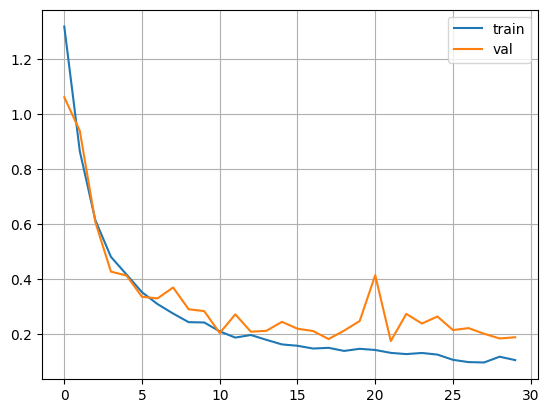

In [103]:
plt.figure()
plt.plot(range(num_epoch),history.history['loss'], label='train')
plt.plot(range(num_epoch),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

Tests

In [104]:
model = load_model('best_model.hdf5.keras')

In [13]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [106]:
sample_l = []
predict_l = []
for idx in range(len(X_val)):
    samples=X_val[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_val[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

In [107]:
print("Sample list", sample_l)
print("Predict list", predict_l)

Sample list [1, 0, 1, 2, 3, 4, 2, 0, 1, 1, 4, 0, 4, 1, 0, 1, 4, 0, 0, 1, 2, 0, 1, 2, 4, 2, 2, 4, 0, 0, 2, 2, 0, 4, 1, 2, 1, 3, 1, 4, 0, 0, 3, 2, 3, 2, 0, 2, 2, 2, 1, 0, 0, 4, 2, 0, 4, 1, 0, 2, 4, 4, 2, 3, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 0, 1, 2, 3, 4, 0, 4, 4, 0, 2, 2, 4, 2, 1, 1, 3, 3, 1, 1, 4, 3, 0, 3, 4, 2, 2, 2, 0, 1, 2, 2, 2, 3, 0, 2, 3, 3, 2, 1, 0, 0, 0, 3, 4, 3, 2, 0, 1, 1, 4, 2, 0, 4, 2, 4, 4, 1, 4, 4, 4, 0, 0, 2, 0, 0, 3, 1, 2, 2, 4, 2, 2, 1, 4, 4, 0, 2, 2, 2, 4, 4, 0, 2, 4, 3, 4, 4, 4, 4, 1, 1, 2, 3, 2, 2, 2, 2, 0, 4, 0, 3, 2, 4, 1, 3, 2, 1, 1, 3, 1, 0, 2, 4, 4, 0, 2, 4, 4, 4, 1, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 4, 0, 3, 3, 4, 2, 0, 3, 1, 1, 3, 1, 3, 2, 2, 2, 2, 3, 2, 4, 1, 1, 3, 3, 4, 0, 3, 1, 0, 4, 4, 1, 3, 4, 1, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 2, 1, 1, 4, 4, 0, 3, 4, 1, 3, 2, 3, 0, 0, 0, 0, 1, 0, 3, 4, 1, 3, 1, 0, 0, 0, 4, 2, 4, 1, 1, 2, 4, 0, 4, 3, 0, 4, 1, 4, 4, 0, 4, 2, 2, 2, 1, 0, 0, 1, 2, 0, 3, 0, 4, 0, 4, 3, 4, 2, 0, 0, 2, 1, 1, 2, 4, 4, 1, 2, 3, 0, 1, 

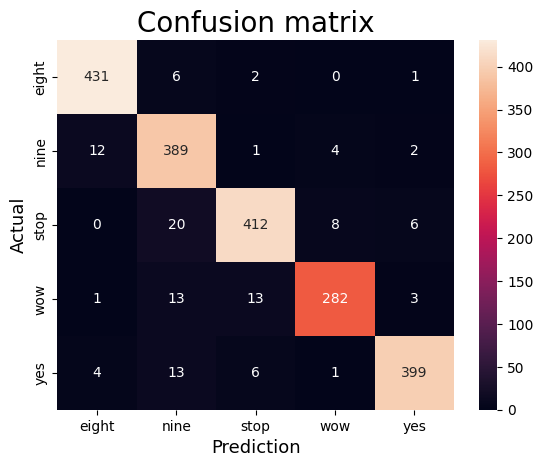

In [108]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [109]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.96      0.98      0.97       440
        nine       0.88      0.95      0.92       408
        stop       0.95      0.92      0.94       446
         wow       0.96      0.90      0.93       312
         yes       0.97      0.94      0.96       423

    accuracy                           0.94      2029
   macro avg       0.94      0.94      0.94      2029
weighted avg       0.94      0.94      0.94      2029



Decreasing datasets by 2

In [25]:
train_dataset = './input/'
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    i = 0
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        i += 1
        if i <= 1000:
            samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
            if(len(samples)== 8000) : 
                all_waves.append(samples)
                all_labels.append(label)
        else:
            break

Preprocessing eight...
Preprocessing nine...
Preprocessing stop...
Preprocessing wow...
Preprocessing yes...


In [26]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

y = to_categorical(y, num_classes=len(chosen_labels))
X = np.array(all_waves).reshape(-1, 8000, 1)

print(X.shape)
print(y.shape)

(4480, 8000, 1)
(4480, 5)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))

X_train len 3584
X_val len 896


In [ ]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_dec2.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [29]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8989 - loss: 0.3842
Epoch 1: val_accuracy improved from -inf to 0.90067, saving model to best_model_dec2.hdf5.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8989 - loss: 0.3836 - val_accuracy: 0.9007 - val_loss: 0.2999
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9226 - loss: 0.2538
Epoch 2: val_accuracy improved from 0.90067 to 0.90960, saving model to best_model_dec2.hdf5.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9225 - loss: 0.2538 - val_accuracy: 0.9096 - val_loss: 0.2353
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9282 - loss: 0.2140
Epoch 3: val_accuracy improved from 0.90960 to 0.91071, saving model to best_model_dec2.hdf5.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9283 - loss: 0.2140 - val_accuracy: 0.9107 - val_loss: 0.2640
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9301 - loss: 0.2036
Epoc

In [30]:
model = load_model('best_model_dec2.hdf5.keras')

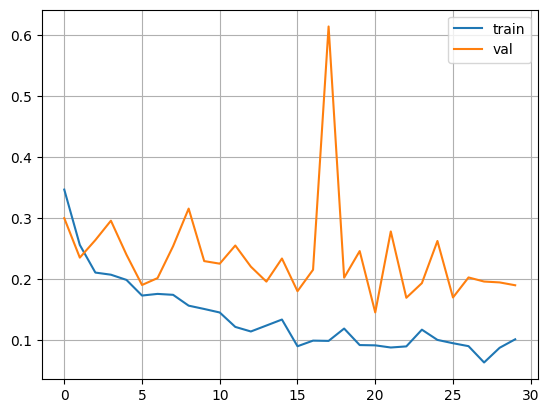

In [33]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [34]:
sample_l = []
predict_l = []
for idx in range(len(X_val)):
    samples=X_val[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_val[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

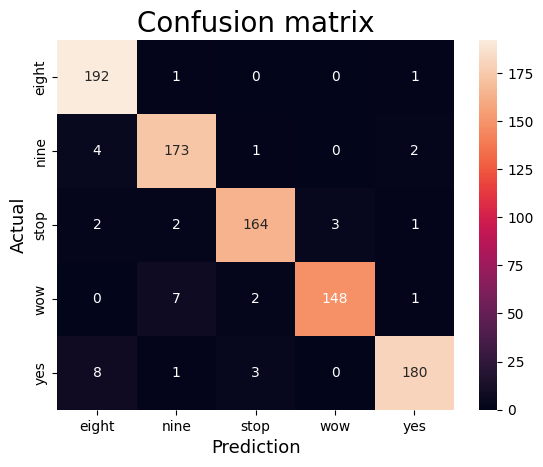

In [35]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [36]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.93      0.99      0.96       194
        nine       0.94      0.96      0.95       180
        stop       0.96      0.95      0.96       172
         wow       0.98      0.94      0.96       158
         yes       0.97      0.94      0.95       192

    accuracy                           0.96       896
   macro avg       0.96      0.96      0.96       896
weighted avg       0.96      0.96      0.96       896



Decreasing datasets by 4

In [38]:
train_dataset = './input/'
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    i = 0
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        i += 1
        if i <= 500:
            samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
            if(len(samples)== 8000) : 
                all_waves.append(samples)
                all_labels.append(label)
        else:
            break

Preprocessing eight...
Preprocessing nine...
Preprocessing stop...
Preprocessing wow...
Preprocessing yes...


In [39]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

y = to_categorical(y, num_classes=len(chosen_labels))
X = np.array(all_waves).reshape(-1, 8000, 1)

print(X.shape)
print(y.shape)

(2261, 8000, 1)
(2261, 5)


In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))

X_train len 1808
X_val len 453


In [ ]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_dec4.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [42]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2342 - loss: 1.5976
Epoch 1: val_accuracy improved from -inf to 0.32450, saving model to best_model_dec4.hdf5.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2349 - loss: 1.5974 - val_accuracy: 0.3245 - val_loss: 1.5451
Epoch 2/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3499 - loss: 1.4873
Epoch 2: val_accuracy improved from 0.32450 to 0.38852, saving model to best_model_dec4.hdf5.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3508 - loss: 1.4859 - val_accuracy: 0.3885 - val_loss: 1.4027
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4783 - loss: 1.2267
Epoch 3: val_accuracy improved from 0.38852 to 0.49448, saving model to best_model_dec4.hdf5.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4789 - loss: 1.2261 - val_accuracy: 0.4945 - val_loss: 1.1826
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5723 - loss: 1.0577
Epoch 4: val_accur

In [43]:
model = load_model('best_model_dec4.hdf5.keras')

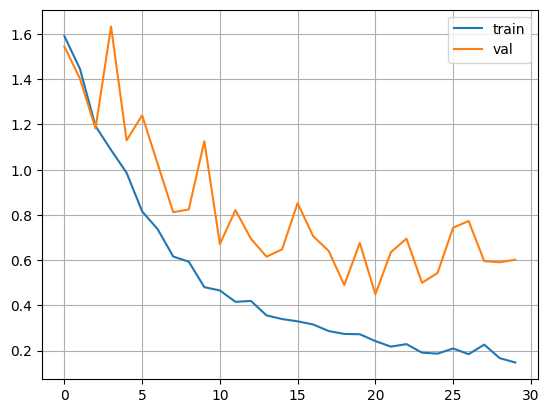

In [44]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [45]:
sample_l = []
predict_l = []
for idx in range(len(X_val)):
    samples=X_val[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_val[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

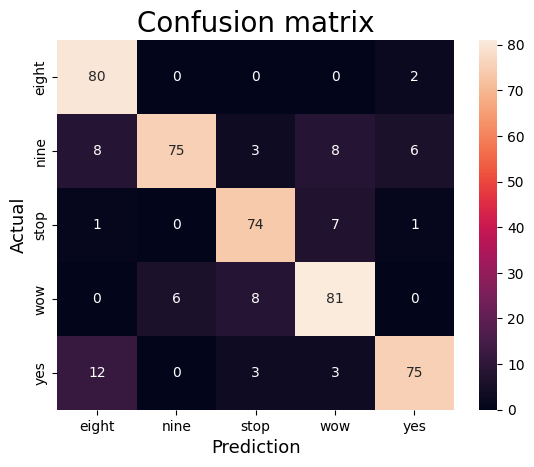

In [46]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [47]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.79      0.98      0.87        82
        nine       0.93      0.75      0.83       100
        stop       0.84      0.89      0.87        83
         wow       0.82      0.85      0.84        95
         yes       0.89      0.81      0.85        93

    accuracy                           0.85       453
   macro avg       0.85      0.86      0.85       453
weighted avg       0.86      0.85      0.85       453



Decreasing dataset by 8

In [48]:
train_dataset = './input/'
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    i = 0
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        i += 1
        if i <= 250:
            samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
            if(len(samples)== 8000) : 
                all_waves.append(samples)
                all_labels.append(label)
        else:
            break

Preprocessing eight...
Preprocessing nine...
Preprocessing stop...
Preprocessing wow...
Preprocessing yes...


In [49]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

y = to_categorical(y, num_classes=len(chosen_labels))
X = np.array(all_waves).reshape(-1, 8000, 1)

print(X.shape)
print(y.shape)

(1133, 8000, 1)
(1133, 5)


In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))

X_train len 906
X_val len 227


In [51]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_dec8.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [53]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2458 - loss: 1.6029
Epoch 1: val_accuracy improved from -inf to 0.29956, saving model to best_model_dec8.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2456 - loss: 1.6026 - val_accuracy: 0.2996 - val_loss: 1.5772
Epoch 2/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2847 - loss: 1.5255
Epoch 2: val_accuracy improved from 0.29956 to 0.40088, saving model to best_model_dec8.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.2872 - loss: 1.5241 - val_accuracy: 0.4009 - val_loss: 1.4760
Epoch 3/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4388 - loss: 1.4131
Epoch 3: val_accuracy improved from 0.40088 to 0.43612, saving model to best_model_dec8.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4384 - loss: 1.4101 - val_accuracy: 0.4361 - val_loss: 1.2910
Epoch 4/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4568 - loss: 1.2051
Epoch 4: val_accur

In [54]:
model = load_model('best_model_dec8.hdf5.keras')

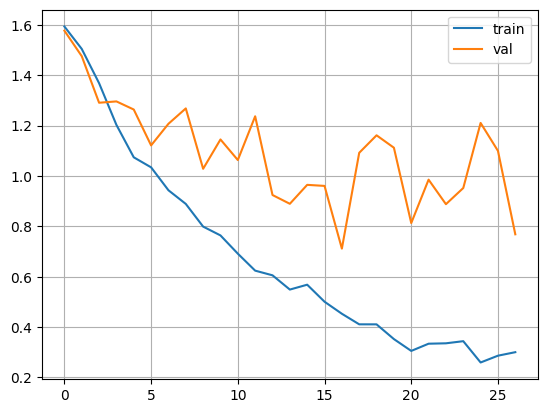

In [55]:
epochs = 27
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [56]:
sample_l = []
predict_l = []
for idx in range(len(X_val)):
    samples=X_val[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_val[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

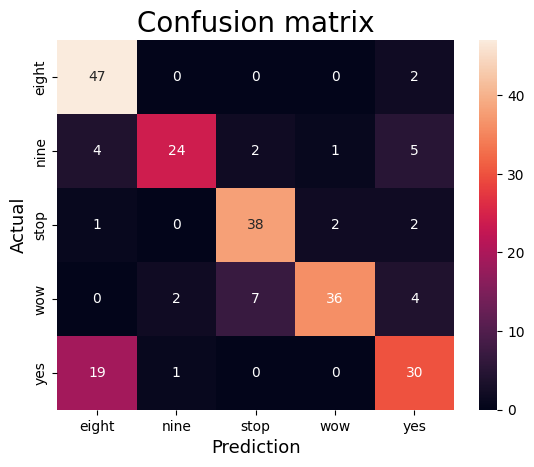

In [57]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [58]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.66      0.96      0.78        49
        nine       0.89      0.67      0.76        36
        stop       0.81      0.88      0.84        43
         wow       0.92      0.73      0.82        49
         yes       0.70      0.60      0.65        50

    accuracy                           0.77       227
   macro avg       0.80      0.77      0.77       227
weighted avg       0.79      0.77      0.77       227



Transfer learning

In [61]:
train_dataset = './input/'
labels = os.listdir(train_dataset)
for label in labels:
    if not os.path.isdir(train_dataset + '/' + label):
        labels.remove(label)
labels.remove('_background_noise_')
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
new_labels = []
while len(new_labels) != 5:
    r_label = str(np.random.choice(labels))
    if r_label not in chosen_labels and r_label not in new_labels:
        new_labels.append(r_label)

print("New labels: ", new_labels)
print("Chosen labels: ", chosen_labels)

New labels:  ['three', 'seven', 'four', 'tree', 'dog']
Chosen labels:  ['eight', 'nine', 'stop', 'wow', 'yes']


In [62]:
train_dataset = './input/'
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    i = 0
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        i += 1
        if i <= 250: # original size of dataset decreased by 8
            samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
            if(len(samples)== 8000) : 
                all_waves.append(samples)
                all_labels.append(label)
        else:
            break

Preprocessing eight...
Preprocessing nine...
Preprocessing stop...
Preprocessing wow...
Preprocessing yes...


In [72]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_
print(y.shape)

(1133,)


In [74]:
y = to_categorical(y, num_classes=len(new_labels))
# y = y[idxs, :]

In [75]:
X = np.array(all_waves).reshape(-1, 8000, 1)
# X = X[idxs, :]

In [76]:
print(X.shape)
print(y.shape)
original_size = y.shape[0]

(1133, 8000, 1)
(1133, 5)


In [77]:
# Data augmentation HERE
for i in range(original_size):
    noise = np.random.randn(len(X[0])).reshape(-1, 1)
    X = np.vstack([X, np.add(X[i], 0.01*noise)[None, :, :]])
    y = np.vstack([y, y[i, :]])

In [78]:
print(X.shape)
print(y.shape)

(2266, 8000, 1)
(2266, 5)


In [80]:
idx = np.random.randint(original_size, 2*original_size)
samples=X[idx].ravel()
print("Audio:",classes[np.argmax(y[idx])])
ipd.Audio(samples, rate=8000)

Audio: stop


In [81]:
for i in range(original_size):
    shift = 1000
    X = np.vstack([X, np.roll(X[i], shift)[None, :, :]])
    y = np.vstack([y, y[i, :]])

In [82]:
print(X.shape)
print(y.shape)

(3399, 8000, 1)
(3399, 5)


In [83]:
idx = np.random.randint(2*original_size, 3*original_size)
samples=X[idx].ravel()
print("Audio:",classes[np.argmax(y[idx])])
ipd.Audio(samples, rate=8000)

Audio: wow


In [84]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))

X_train len 2719
X_val len 680


In [85]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_aug.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [87]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2394 - loss: 1.5840
Epoch 1: val_accuracy improved from -inf to 0.30294, saving model to best_model_aug.hdf5.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2397 - loss: 1.5838 - val_accuracy: 0.3029 - val_loss: 1.5292
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3573 - loss: 1.4529
Epoch 2: val_accuracy improved from 0.30294 to 0.38235, saving model to best_model_aug.hdf5.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.3573 - loss: 1.4526 - val_accuracy: 0.3824 - val_loss: 1.4107
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4693 - loss: 1.2677
Epoch 3: val_accuracy improved from 0.38235 to 0.63529, saving model to best_model_aug.hdf5.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4698 - loss: 1.2667 - val_accuracy: 0.6353 - val_loss: 1.0413
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6197 - loss: 0.9603
Epoch 4: val_accuracy

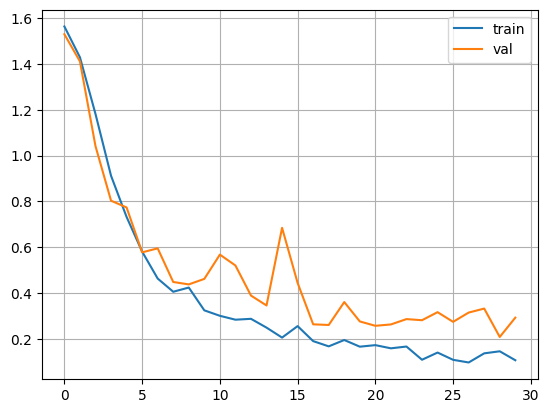

In [88]:
plt.figure()
plt.plot(range(num_epoch),history.history['loss'], label='train')
plt.plot(range(num_epoch),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [89]:
model = load_model('best_model_aug.hdf5.keras')

In [90]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [91]:
sample_l = []
predict_l = []
for idx in range(len(X_val)):
    samples=X_val[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_val[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

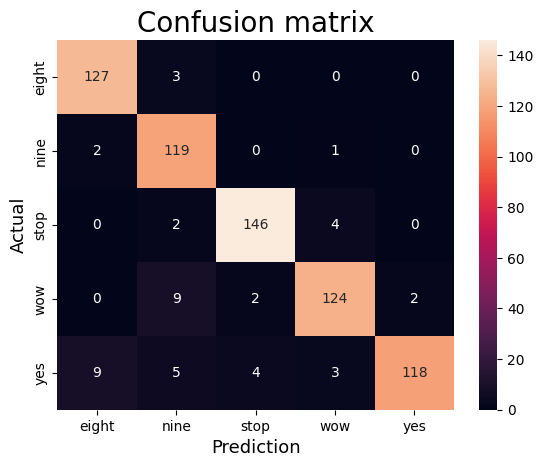

In [92]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [93]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.92      0.98      0.95       130
        nine       0.86      0.98      0.92       122
        stop       0.96      0.96      0.96       152
         wow       0.94      0.91      0.92       137
         yes       0.98      0.85      0.91       139

    accuracy                           0.93       680
   macro avg       0.93      0.93      0.93       680
weighted avg       0.94      0.93      0.93       680



Check your voice sample: 

In [85]:
samplerate = 16000
duration = 1
filename = 'voice.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)


start
end


In [86]:
#reading the voice commands
samples, sample_rate = librosa.load('voice.wav', sr = 16000)
samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples,rate=8000) 

In [87]:
result = predict(samples)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
up
